In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost.datasets import titanic

## Градиентный бустинг на решающих деревьях

- [XGBoost](https://github.com/dmlc/xgboost) --- eXtreme Gradient Boosting
- [Yandex CatBoost](https://github.com/catboost/catboost)
- [Сравнение библиотек (CatBoost vs. Light GBM vs. XGBoost)](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

`XGBoost` строит композицию из $T$ базовых моделей $b_t$:
$$ \widehat{y} = \widehat{y}_{T} = \sum_{t=1}^{T} b_t = \widehat{y}_{T - 1} + b_T, $$

минимизируя следующий функционал:

$$ Q = \sum_{i=1}^N \mathcal{L}\left(y_i, \widehat{y}_T(x_i)\right) + \sum_{t=1}^{T} R(b_t),$$

где
 - $n$ --- размер обучающей выборки;
 - $x_i, y_i$ --- объекты обучающей выборки, и соответствующие истинные значения отклика;
 - $\widehat{y}_{t}$ --- композиция из $t$ уже обученных базовых моделей;
 - $R$ --- регуляризатор;
 - $\mathcal{L}(y_i, \widehat{y}_i)$ --- функция потерь.


Функционал, оптимизируемый на $t$-ой итерации:

$$ Q_t = \sum_{i=1}^N \mathcal{L}\left(y_i, \widehat{y}_{t-1}(x_i) + b_t(x_i)\right) + R(b_t) \longrightarrow \min_{b_t}.$$

Рассмотрим бустинг над решающими деревьями. Пусть $b_t$ -- дерево, $\gamma = (\gamma_j)_{j=1}^J$ - набор ответов в листьях этого дерева, а $J$ - количество листьев. Тогда в таком случае регуляризатор имеет следующий вид:

$$ R(b_t) = \eta J + \frac{1}{2}\lambda\sum_{j=1}^{J}\gamma_j^2 + \alpha\sum_{j=1}^{J}|\gamma_j|,$$

где 
 - $J$ --- количество листьев в дереве;
 - $\gamma_j$ --- ответы в листьях дерева;
 - $\lambda, \alpha, \gamma$ --- гиперпараметры.

# 1. XGBoost

Будем обучать модели на датасете `Boston Housing`.

In [2]:
boston = load_boston()
y = boston['target']
X = boston['data']

kf = KFold(n_splits=3, shuffle=True, random_state=42)

### 1.1 **sklearn-интерфейс**

Библиотека `XGBoost` имеет `sklearn`-like обертку, а именно, основные методы `fit` и `predict`. Это позволяет использовать `XGBoost`-модели в `sklearn`-утилитах, таких как `GridSearchCV` или `cross_val_score`. 
Для этого используются классы `XGBRegressor` или `XGBClassifier`.

Рассмотрим `XGBRegressor` и проведем кросс-валидацию на 3 фолда:

In [3]:
xgb_model = XGBRegressor(silent=True, max_depth=4, n_estimators=200)

cross_val_score(xgb_model, X, y, scoring='neg_mean_squared_error', cv=5)

array([-10.24322065, -15.78511248, -13.87035687, -39.07195897,
       -18.06476308])

Или так:

In [4]:
for fold_index, (train_index, test_index) in enumerate(kf.split(y)):
    xgb_model = XGBRegressor().fit(X[train_index], y[train_index])
    
    xgb_predictions = xgb_model.predict(X[test_index])
    
    actuals = y[test_index]
    print("RMSE on fold {}. XGBoost: {:.2f}".format(
        fold_index, np.sqrt(mean_squared_error(actuals, xgb_predictions)))
    )

RMSE on fold 0. XGBoost: 2.83
RMSE on fold 1. XGBoost: 4.22
RMSE on fold 2. XGBoost: 2.90


### 1.2 **Нативный интерфейс**

У `XGBoost` также есть свой нативный интерфейс, и `sklearn`-интерфейс использует его внутри себя.

Переход из `sklearn`-интерфейса в нативный осуществляется с помощью метода `get_booster()`:

In [5]:
native_xgb_model = xgb_model.get_booster()

Для хранения данных в нативном интерфейсе используется класс `xgboost.DMatrix`. Он хранит в себе:
  - `data` -- матрица объект-признак;
  - `label` -- вектор с таргетом (для обучения и валидации);
  - `weight` -- вектор весов объектов;
  - `feature_names` -- названия признаков.
  
Данные можно легко перевести в объект `DMatrix` из `csv`-файла, `numpy`-массива и `pandas-dataframe`. 

In [6]:
xgtrain = DMatrix(X[train_index], label=y[train_index]) # missing=-999.0, weight=w
xgtest = DMatrix(X[test_index], label=y[test_index])

Функция `xgboost.train()` обучает модель. Принимает на вход `DMatrix`, словарь с гиперпараметрами модели и еще всякие опции для обучения через аргументы. 
 
Возвращает бустер (класс `xgboost.booster`). У бустера есть метод `predict`, который делает предсказания.


[Подробнее](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

In [7]:
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True
}

bst = xgb.train(params, xgtrain, num_boost_round=20)

### 1.3 Гиперпараметры XGBoost

Гиперпараметры модели передаются в нативном интерфейсе с помощью словаря `params`, а в `sklearn`-овском, как всегда, в конструкторе при создании объекта класса.

### Основные параметры:

* `booster` -- вид базовых моделей: `{gbtree, gblinear, dart}`. <br>
$\;\;\;$ `gbtree` -- использует деревья.<br>
$\;\;\;$ `dart` -- использует деревья с dropout (вспоминаем прошлый семинар).<br>
$\;\;\;$ `gblinear` -- использует линейные модели.<br>

* `eta` или `learning rate` -- скорость обучения
* `gamma` -- параметр в регуляризации на количество листьев
* `max_depth` -- максимальная глубина дерева
* `subsample` -- доля объектов, на которых обучается каждое дерево. Для каждого дерева выбирается свой набор
* `alpha` -- параметр `L1`-регуляризации
* `lambda` -- параметр `L2`-регуляризации 
* `tree_method` -- параметр, отвечающий за то, как перебираются пороги и признаки при построении одного дерева: `{auto, exact, approx, hist, gpu_exact, gpu_hist}`. Параметр будет описан далее.

* `objective` -- лосс, который будем минимизировать: `{reg:linear, reg:logistic, binary:logistic, binary:hinge, multi:softmax, ...}` <br>
$\;\;\;$ `reg:linear` -- квадратичная ошибка.<br>
$\;\;\;$    `reg:logistic` = `binary:logistic`. Единственная разница в том, что в случае регрессии в качестве `eval_metric` будет использоваться `RMSE`.<br>
$\;\;\;$ Есть еще большое множество лосс-функций для регрессии, бинарной/мульти классификации, ранжирования и прочих задач. <br>
$\;\;\;$ [Подробнее про доступные лоссы](https://xgboost.readthedocs.io/en/latest/parameter.html)<br>

* `eval_metric` -- метрика, которую будем измерять. По умолчанию получается из параметра `objective`: для регрессии `RMSE`, для классификации - `error (он же: 1 - accuracy)`. <br>
$\;\;\;$ Можно указать сразу несколько метрик, тогда будут измеряться сразу все.
$\;\;\;$  Возможные значения : `RMSE`, `MAE`, `logloss`, `error`, `AUC`  и множетсво остальных. <br>
$\;\;\;$ [Подробнее про доступные метрики](https://xgboost.readthedocs.io/en/latest/parameter.html) <br>

* Количество базовых моделей `num_boost_round` указывается явно в аргументах функции `train()`, а не в словаре параметров. В `sklearn`-обертке за это отвечает параметр `n_estimators`.

У метода `train` есть параметр `evals`, в который можно передать массив вида `[(dtest, 'eval'), (dtrain, 'train')]`, где `dtest`, `dtrain` - `DMatrix`-объекты. Тогда после каждой итерации бустинга будет выводиться значение метрик из `eval_metric` для каждого из наборов.

Также у метода `train` есть параметр `early_stopping_rounds`. В случае если этот параметр равен `k`, то после `k` итераций бустинга, которые не сопровождались уменьшением лосса для валидационного сета, указанного в `evals`, обучение будет остановлено.
<br>

Также для `XGBoost` есть возможность запускаться на `Hadoop`, `Spark`, `Flink` и `DataFlow`.

Обучим модель:

In [8]:
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True
}

evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
bst = xgb.train(params, xgtrain, num_boost_round=20, evals=evallist)

bst.eval(xgtest)

[0]	eval-rmse:17.29885	train-rmse:17.09866
[1]	eval-rmse:12.66154	train-rmse:12.40409
[2]	eval-rmse:9.53978	train-rmse:9.05176
[3]	eval-rmse:7.40142	train-rmse:6.73095
[4]	eval-rmse:6.01272	train-rmse:5.03787
[5]	eval-rmse:5.05086	train-rmse:3.84373
[6]	eval-rmse:4.45467	train-rmse:3.02596
[7]	eval-rmse:4.12493	train-rmse:2.43534
[8]	eval-rmse:3.85675	train-rmse:2.03269
[9]	eval-rmse:3.65495	train-rmse:1.72251
[10]	eval-rmse:3.54903	train-rmse:1.49709
[11]	eval-rmse:3.49831	train-rmse:1.36663
[12]	eval-rmse:3.43492	train-rmse:1.27651
[13]	eval-rmse:3.38899	train-rmse:1.20330
[14]	eval-rmse:3.37120	train-rmse:1.11684
[15]	eval-rmse:3.35757	train-rmse:1.05976
[16]	eval-rmse:3.34673	train-rmse:1.00846
[17]	eval-rmse:3.33874	train-rmse:0.97518
[18]	eval-rmse:3.32229	train-rmse:0.92053
[19]	eval-rmse:3.32346	train-rmse:0.86042


'[0]\teval-rmse:3.323460'

Также можем использовать кросс-валидацию:



In [9]:
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True
}

for fold_index, (train_index, test_index) in enumerate(kf.split(y)):    
    xgtrain = DMatrix(X[train_index], label=y[train_index])
    xgtest = DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain, num_boost_round=100)

    print("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))

RMSE on fold 0: [0]	eval-rmse:3.030949
RMSE on fold 1: [0]	eval-rmse:4.425540
RMSE on fold 2: [0]	eval-rmse:3.262767


### 1.4 Своя функция потерь

В `XGBoost` имеется возможность реализовать свои метрики и функции потерь.

Для функций потерь необходимо уметь считать градиент и гессиан (точнее, его главную диагональ).

Разделим данные на `train`, `val` и `test`:

In [10]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.25)
X_validate, X_test, y_validate, y_test = train_test_split(
    X_rest, y_rest, test_size=0.5
)

Определим свою функцию потерь MSE. Она должна возвращать градиент и главную диагональ гессиана:

In [11]:
def my_xgb_reg_linear(preds, dtrain):
    # извлекаем истинные метки классов
    labels = dtrain.get_label()
    # градиент функции потерь по ответам
    grad = (preds - labels)
    # вторые производные
    hess = np.ones(labels.shape[0])
    return grad, hess

Обучим нашу модель, используя свою функцию потерь. Качество на тесте и валидации -- `RMSE`:

In [12]:
xgtrain = xgb.DMatrix(X_train, label=y_train, 
                      feature_names=boston['feature_names'])
xgvalidate = xgb.DMatrix(X_validate, label=y_validate, 
                         feature_names=boston['feature_names'])
xgtest = xgb.DMatrix(X_test, label=y_test, 
                     feature_names=boston['feature_names'])

bst = xgb.train(
    params, xgtrain, num_boost_round=200, obj=my_xgb_reg_linear,
    evals=[(xgvalidate, "validate"), (xgtest, "test")], verbose_eval=50
)

print(bst.eval(xgtest))

[0]	validate-rmse:18.14445	test-rmse:16.93044
[50]	validate-rmse:2.73642	test-rmse:3.13560
[100]	validate-rmse:2.71320	test-rmse:3.11851
[150]	validate-rmse:2.71276	test-rmse:3.11800
[199]	validate-rmse:2.71262	test-rmse:3.11817
[0]	eval-rmse:3.118173


### 1.5 Важность признаков



С помощью функции `get_fscore` мы можем посмотреть сколько раз каждый признак использовался в качестве разделяющего при построении дерева:

In [13]:
# Обучение модели
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True
}
bst = xgb.train(params, xgtrain, num_boost_round=100)

# Важность признаков
fstrs = bst.get_fscore()

# Печать
for name, value in Counter(bst.get_fscore()).most_common():
    print("{}\t{}".format(name, value))

CRIM	740
RM	426
AGE	391
LSTAT	331
DIS	312
B	280
NOX	221
INDUS	92
TAX	79
PTRATIO	70
ZN	57
RAD	39
CHAS	13


Отрисуем график Feature inportance для нашего бустинга:

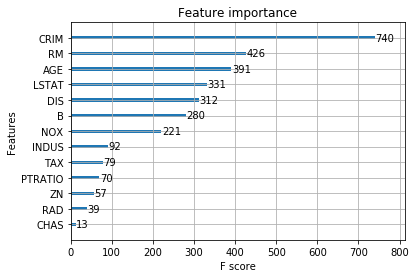

In [14]:
xgb.plot_importance(bst)
plt.show()

### 1.6 Бинаризация признаков в XGBoost

Использовать все возможные значения каждого признака для выбора разбиения -- очень накладно. Поэтому обычно значения признака разбиваются на небольшое число корзин (бины). Существуют разные стратегии выбора бинов.

Стратегии задаются параметром `tree_method`. 

Возможные значения:
  - `exact` -- используются всевозможные значения факторов;
  - `approx` -- на каждой итерации бины пересчитываются (хитрым способом, в зависимости от значений градиента). Более того, можно пересчитывать локально для каждой вершины строящегося дерева. Параметр `sketch_eps` задает примерное кол-во бинов (число бинов ~ `1/sketch_eps`);
  - `hist` -- гистограмма, которая считается один раз перед обучением -- работает гораздо быстрее выше представленных стратегий (в 8-10 раз) без особой потери качества.

In [15]:
for tree_method in ["exact", "approx", "hist"]:
    params = {
        "tree_method": tree_method,
        "sketch_eps": 0.2,
        "silent": True
    }
    bst = xgb.train(params, xgtrain, num_boost_round=100)
    print("binarization: {}\t, score: {}".format(tree_method, 
                                                 bst.eval(xgvalidate)))

binarization: exact	, score: [0]	eval-rmse:2.219110
binarization: approx	, score: [0]	eval-rmse:3.333604
binarization: hist	, score: [0]	eval-rmse:2.712875


# 2. CatBoost

Аналогом для класса `DMatrix` в `CatBoost` служит класс `catboost.Pool` Помимо прочего, этот класс содержит индексы категориальных признаков.

[Подробнее](https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_pool-docpage/)

[Метрики и функции потерь](https://tech.yandex.com/catboost/doc/dg/concepts/loss-functions-docpage/#loss-functions__regression)

Для выбора количества деревьев нужно указать один из параметров: `iterations`, `num_boost_round`, `n_estimators`, `num_trees` (это все синонимы)

Классы `CatBoostClassifier` и `CatBoostRegressor` можно использовать в `GridSearch` и прочих, так как они имеют такой же интерфейс, что `sklearn`-методы.

In [16]:
boston = load_boston()
y = boston['target']
X = boston['data']

kf = KFold(n_splits=3, shuffle=True, random_state=42)



С помощью `CatBoostRegressor` обучим модель, при этом сделаем разбиение на 3 фолда.

In [17]:
for fold_index, (train_index, test_index) in enumerate(kf.split(y)):
    cb_model = CatBoostRegressor(silent=True).fit(X[train_index], 
                                                  y[train_index])

    cb_predictions = cb_model.predict(X[test_index])
    
    actuals = y[test_index]
    print("RMSE on fold {}. CatBoost: {:.2f}".format(
        fold_index, np.sqrt(mean_squared_error(actuals, cb_predictions))
    ))

RMSE on fold 0. CatBoost: 2.98
RMSE on fold 1. CatBoost: 3.94
RMSE on fold 2. CatBoost: 2.83


Для проведения кросс-валидации также можем использовать `cross_val_score` из `sklearn`:

In [18]:
cb_model = CatBoostRegressor(silent=True)

cross_val_score(cb_model, X[train_index], y[train_index], 
                scoring='neg_mean_squared_error', cv=5)

array([ -6.11093337, -15.78759461, -22.43126528, -53.47984363,
       -12.25060619])

Используем `Pool` для хранения данных:

In [19]:
train_data = Pool(
    data=X[train_index],
    label=y[train_index],
    weight=np.random.rand(len(train_index)) # Присваиваем веса объектам, если хотим
    # cat_features=[0,2,5]
)

test_data = Pool(
    data=X[test_index],
)

model = CatBoostRegressor(silent=True)

model.fit(train_data)
cb_predictions = model.predict(test_data)
actuals = y[test_index]
print("CatBoost MSE: {:.2f}".format(
    np.sqrt(mean_squared_error(actuals, cb_predictions))
))

CatBoost MSE: 2.86


### 2.1 Своя функция потерь в CatBoost

[Пример реализации logloss](https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/#custom-objective-function).

Теперь реализуем `взвешенную MSE`: будем учитывать при этом веса объектов.

Реализуемую функцию потерь в `CatBoost` необходимо **максимизировать**.

Поэтому в нашем случае она поменяет знак:

$$ \mathcal{L}\left(y_i, p_i, w_i\right) = -\frac{1}{2}w_i(p_i - y_i)^2, $$
где
 - $y_i$ -- истинные метки;
 - $p_i$ -- наши предсказания;
 - $w_i$ -- веса объектов, задаваемые пользователем.

In [20]:
class MyCatBoostRegLinear(object):
    def calc_ders_range(self, approxes, targets, weights=None):
        '''
        Реализация функции потерь.
        Аргументы:
        * approxes -- предсказания
        * targets -- целевые метки
        * weights -- веса объектов
        
        Возвращает список, в котором для каждого объекта выборки находится tuple
        из градиента и гессиана.
        '''

        assert len(approxes) == len(targets)
        
        # Если веса не заданы, то есть обычное MSE
        if weights is None:
            return [(-approxes[i] + targets[i], -1.0) 
                    for i in range(len(approxes))]
        
        # Если веса заданы, то есть взвешенное MSE
        else:
            assert len(approxes) == len(weights)
            return [(-weights[i] * (approxes[i] - targets[i]), -weights[i])
                    for i in range(len(approxes))]


Обучим катбуст с нашей функцией потерь

In [21]:
cb = CatBoostRegressor(metric_period=100,
                       loss_function=MyCatBoostRegLinear(),
                       eval_metric="RMSE")

cb.fit(X_train, y_train, eval_set=[(X_validate, y_validate)])
pred = cb.predict(X[test_index])

print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y[test_index], pred))))

0:	learn: 23.6380262	test: 25.1092749	best: 25.1092749 (0)	total: 7.85ms	remaining: 7.84s
100:	learn: 4.1190710	test: 6.2535054	best: 6.2535054 (100)	total: 704ms	remaining: 6.27s
200:	learn: 2.3808199	test: 4.7029879	best: 4.7029879 (200)	total: 1.05s	remaining: 4.19s
300:	learn: 1.8649757	test: 4.3367222	best: 4.3367222 (300)	total: 1.43s	remaining: 3.32s
400:	learn: 1.5647241	test: 4.1837857	best: 4.1837857 (400)	total: 1.92s	remaining: 2.86s
500:	learn: 1.3135430	test: 4.0984396	best: 4.0984396 (500)	total: 2.26s	remaining: 2.25s
600:	learn: 1.1127434	test: 4.0344694	best: 4.0344694 (600)	total: 3.03s	remaining: 2.01s
700:	learn: 0.9653415	test: 3.9939389	best: 3.9939389 (700)	total: 3.67s	remaining: 1.57s
800:	learn: 0.8423384	test: 3.9823744	best: 3.9823744 (800)	total: 4.26s	remaining: 1.06s
900:	learn: 0.7324541	test: 3.9720666	best: 3.9720666 (900)	total: 4.89s	remaining: 538ms
999:	learn: 0.6505340	test: 3.9594333	best: 3.9594333 (999)	total: 5.21s	remaining: 0us

bestTest = 

### 2.2 Визуализация

В `CatBoost` имеется возможность строить кривые обучения в режиме реального времени. Для сохранения графиков в ноутбуке нужно нажать `Widgets` -> `Save Notebook Widget State`.

In [22]:
cb = CatBoostRegressor(silent=True, eval_metric="MAE", custom_metric=["MAPE"])
cb.fit(X_train, y_train, 
       eval_set=[(X_validate, y_validate), (X_test, y_test)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 2.3 Построение дерева

Деревья в `CatBoost` строятся по слоям. При этом используются `oblivious decision trees`, то есть на каждом уровне дерева выбирается общее правило ветвления для всех вершин на этом уровне.

Сплит выбирается из соображений наилучшего приближения вектора градиента.

 ### 2.4 Бинаризация признаков в CatBoost
 
 Использовать все возможные значения каждого признака для выбора разбиения -- очень накладно. Поэтому обычно значения признака разбиваются на небольшое число корзин (бины). Существуют разные стратегии выбора бинов.
 
 Выбрать стратегию бинаризации можно, установив параметр `feature_border_type`.
 
  - `Uniform` -- границы выбираются равномерно по значениям;
  - `Median` -- в каждый бин попадает примерно одинаковое число различных значений;
  - `UniformAndQuantiles` -- Uniform + Median;
  - `MaxLogSum, GreedyLogSum` максимизируется значение формулы $\sum_{i=1}^K \log(n_i)$, где $K$ -- требуемое кол-во бинов, $n_i$ -- число объектов в этом бакете;
  - `MinEntropy` -- аналогично, но максимизируется энтропия: $-\sum_{i=1}^K n_i \log(n_i)$

Для каждой стратегии бинаризации посчитаем `MSE` и найдем оптимальную:

In [23]:
params = {
    "feature_border_type": [
      "Uniform",
      "Median",
      "UniformAndQuantiles",
      "MaxLogSum",
      "GreedyLogSum",
      "MinEntropy"
      ]
}

cb = CatBoostRegressor(silent=True)
grid = GridSearchCV(cb, params, cv=5)
grid.fit(X, y)

for score, strategy in sorted(
    zip(grid.cv_results_['mean_test_score'],
    grid.cv_results_['param_feature_border_type'].data)
):
    print("MSE: {:.3f}, strategy: {}".format(score, strategy))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MSE: 0.669, strategy: Uniform
MSE: 0.675, strategy: GreedyLogSum
MSE: 0.680, strategy: MaxLogSum
MSE: 0.680, strategy: MinEntropy
MSE: 0.681, strategy: UniformAndQuantiles
MSE: 0.687, strategy: Median


### 2.5 Важность признаков

In [24]:
cb = CatBoostRegressor(silent=True)
cb.fit(X_train, y_train)

for value, name in sorted(
    zip(cb.get_feature_importance(fstr_type="FeatureImportance"), 
        boston["feature_names"]), 
    reverse=True
):
    print("{}\t{:.2f}".format(name, value))

RM	32.36
LSTAT	26.86
DIS	7.68
NOX	6.39
PTRATIO	4.79
CRIM	4.78
B	4.14
AGE	3.45
TAX	3.34
RAD	2.07
INDUS	1.90
CHAS	1.28
ZN	0.95


### 2.6 Категориальные признаки

Одно из основных преимуществ `CatBoost` -- обработка категориальных признаков.

Если количество различных значений признака небольшое, то для его кодировки применяется `one-hot-encodding`.
Иначе применяется `target-encoding`: признак заменяется на статистики по тагретам объектов, которые имеют данное значение категориального признака.

Такие манипуляции очень легко могут привести к переобучению, потому что в данные подмешивается информация о метках объектов, после чего происходит обучение. `CatBoost` инкапсулирует все эти опасные вычисления.

Особенности работы с категориальными факторами: 

  - объекты перемешиваются в случайном порядке;
  - для $i$-го объекта в перестановке статистика вычисляется по всем объектам, идущим **до него**, категориальный фактор заменяется на числовой;
  - среднее сглаживается некоторым априорным приближением;
  - по факту обучается несколько (3) модели на разных перестановках;
  - рассматриваются композиции категориальных факторов (`max_ctr_complexity`);
  - в момент применения модели, новые объекты приписываются в конец перестановки по обучающей выборке и, таким образом, статистика для них считается по всем имеющимся данным;
  - таргето-независимые статистики (`mean-encoding`) считаются по всем данным.
  - для факторов с небольшим числом различных значений производится `OneHotEncoding` (параметр `one_hot_max_size` - максимальное значение для `OneHotEncoding'а`)

Попробуем поработать с категориальными признаками на датасете титаник. В нем представлена базовая информация о пассажире лайнера, а также бинарная метка выжил/не выжил в крушении, которую и требуется предсказать.

In [25]:
titanic_df = titanic()

X = titanic_df[0].drop('Survived',axis=1)
y = titanic_df[0].Survived

In [26]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Найдем категориальные столбцы, а также заполним пропуски в них:

In [27]:
is_cat = (X.dtypes != float)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]

Создаем `Pool`, в которых кроме прочего указываем индексы категориальных столбцов.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=.85, random_state=1234
)

train_pool = Pool(X_train, label=y_train, cat_features=cat_features_index, 
                  feature_names=list(X_train.columns))
test_pool = Pool(X_test, label=y_test, cat_features=cat_features_index, 
                 feature_names=list(X_test.columns))

Обучааем `CatBoostClassifier`. Будем после каждых `metric_period=100` итераций смотреть на метрику на `eval_set`-е. В итоге будем использовать модель, полученную на лучшей по метрике итерации (`use_best_model=True`).

In [29]:
model = CatBoostClassifier(eval_metric='Accuracy', 
                           use_best_model=True, random_seed=0)

model.fit(train_pool, eval_set=test_pool, metric_period=100)
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

Learning rate set to 0.029583
0:	learn: 0.7820343	test: 0.8134328	best: 0.8134328 (0)	total: 2.79ms	remaining: 2.78s
100:	learn: 0.8612946	test: 0.8358209	best: 0.8358209 (100)	total: 874ms	remaining: 7.78s
200:	learn: 0.8837517	test: 0.8507463	best: 0.8507463 (200)	total: 2.46s	remaining: 9.77s
300:	learn: 0.9009247	test: 0.8358209	best: 0.8507463 (200)	total: 3.72s	remaining: 8.65s
400:	learn: 0.9167768	test: 0.8432836	best: 0.8507463 (200)	total: 5.07s	remaining: 7.58s
500:	learn: 0.9260238	test: 0.8507463	best: 0.8507463 (200)	total: 6.23s	remaining: 6.21s
600:	learn: 0.9352708	test: 0.8507463	best: 0.8507463 (200)	total: 7.53s	remaining: 5s
700:	learn: 0.9418758	test: 0.8283582	best: 0.8507463 (200)	total: 8.59s	remaining: 3.66s
800:	learn: 0.9498018	test: 0.8208955	best: 0.8507463 (200)	total: 9.77s	remaining: 2.43s
900:	learn: 0.9564069	test: 0.8134328	best: 0.8507463 (200)	total: 11.4s	remaining: 1.25s
999:	learn: 0.9603699	test: 0.8283582	best: 0.8507463 (200)	total: 12.5s	rem

0.8727272727272725